# AuxTel validation with CWFS test data from 210323

Owner: **Chris Suberlak** ([@suberlak](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@suberlak))
<br>Last Verified to Run: **2022-04-21**
<br>Software Versions:
  - `ts_wep`: **v2.3.4**
  - `lsst_distrib`: **w_2022_16**
  
## Goal

Use test data from CWFS unit tests https://github.com/lsst-ts/ts_externalscripts/blob/develop/tests/auxtel/test_latiss_cwfs_align.py#L222
https://github.com/lsst-ts/ts_externalscripts/blob/develop/tests/auxtel/test_latiss_cwfs_align.py#L412 , i.e. exposures 2021032300308 and  2021032300310


## Setup:
    
   * access to NCSA lsst-devl nodes 
   * working installation of ts_wep package ( see the following [notes](https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS) for additional info on how to install and build the AOS packages)
    
It is assumed that `ts_analysis_notebooks` resides in `$PATH_TO_TS_ANALYSIS_NOTEBOOKS`. Here it was `/project/scichris/aos/ts_analysis_notebooks`.

At least once after cloning the `ts_analysis_notebooks` repo one needs to run the `setup` and `scons` commands. It can be  for example:
   
    cd $PATH_TO_TS_ANALYSIS_NOTEBOOKS
    setup -k -r .
    scons 

Setup (that was used to run the analysis on a notebook opened in a browser using an ssh connection to the NCSA machine). The `54467` can be any other port number, as long as it is consistent between `ssh` connection and the jupyter notebook. 

Run in the terminal on the local machine:

    ssh -L 54467:localhost:54467 $USER@lsst-devl02
    
Run in the NCSA terminal after DUO authentication:

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib    
    source /project/scichris/aos/setup_aos_current.sh 
    setup -k -r $PATH_TO_TS_ANALYSIS_NOTEBOOKS
    jupyter notebook --no-browser --port=54467    
   
This should open the browser at the NCSA `/jhome` directory.  I navigate to `$PATH_TO_TS_ANALYSIS_NOTEBOOKS` to open this notebook.

## Imports

In [6]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy.table import Table

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

import numpy as np
from copy import copy
import yaml

from lsst.ts.wep.task.EstimateZernikesLatissTask import (EstimateZernikesLatissTask, 
EstimateZernikesLatissTaskConfig)
from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig
)
from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector
from lsst.daf import butler as dafButler


## Run the ISR 

In [1]:
%matplotlib inline

def preview_auxtel_exposures(year, monthDay, expStart, expEnd,
                            datasetRefOrType='raw', collection='LATISS/raw/all'):

    butler = dafButler.Butler('/repo/main/')
    
    # figure out how many images to plot
    nexp = expEnd-expStart

    # calculate how many cols and rows we need 
    if nexp > 3:
        ncol = 3
        nrows = (nexp // ncol) + 1
    else:
        ncol=nexp
        nrows = 1
    
    zscale = ZScaleInterval()
    
    # do the plotting 
    fig,axs = plt.subplots(nrows,ncol,figsize=(ncol*4,nrows*4))
    ax = np.ravel(axs)
    i=0
    for exp in range(expStart,expEnd):
        exposure = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                         'exposure':int(f'{year}{monthDay}00{exp}')
                                            },
                          collections=[collection])
        data = exposure.image.array
        vmin, vmax = zscale.get_limits(data)
        ax[i].imshow(data,vmin=vmin,vmax=vmax,origin=
                  'lower')
        ax[i].set_title(f"{year}{monthDay}, exp {exp},\n focusz={np.round(exposure.getMetadata()['FOCUSZ'],3)}")
        i += 1
    fig.subplots_adjust(hspace=0.25)

    # if there are more axes than exposures,
    # turn off the extra axes 
    ncells = nrows*ncol
    if ncells > nexp:
        for axis in ax[nexp:]:
            axis.axis("off")

Run the ISR: 

    ssh lsst-devl02

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib

    pipetask run  --data-query "exposure IN (2021032300307,2021032300308,2021032300309,2021032300310,2021032300311,2021032300312) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/postISRtest2 --pipeline /project/scichris/aos/testLatiss4.yaml  --register-dataset-types
    
    
  

Show the postISR:

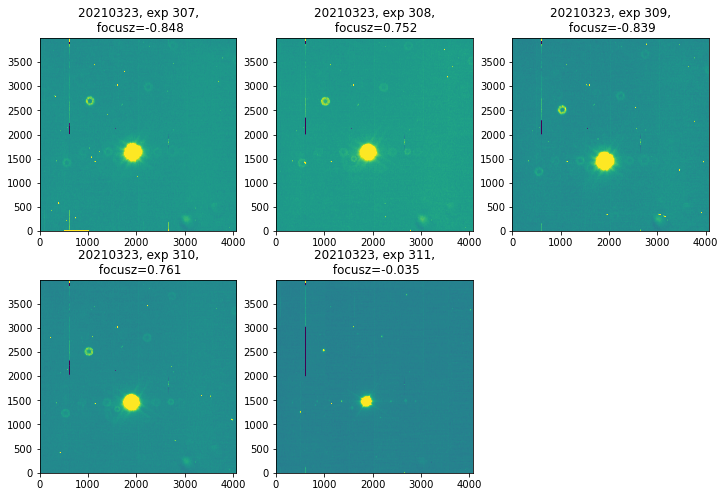

In [2]:
%matplotlib inline
preview_auxtel_exposures(datasetRefOrType='postISRCCD', collection='u/scichris/Latiss/postISRtest',
                        year='2021', monthDay='0323', expStart=307, expEnd=312)

## Fit Zernikes

Run the donut detection via template fitting, and perform Zernike estimation. Store the results.

In [4]:
def fit_zernikes(donutDetectTask,estimateZernikeTask,
                 expIntra, expExtra, 
                 yearMonthDay,
                 collection, 
                 use_extra=False):
    # load the intra and extra-focal exposures 
    exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{yearMonthDay}00{expIntra}')
                                                }, collections=[collection])

    exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{yearMonthDay}00{expExtra}')
                                                }, collections=[collection])
    camera = butler.get("camera",dataId={"instrument": "LATISS"}, 
                        collections=[collection],)
    
    # find donuts from one of the exposures
    if use_extra:
        exposure = copy(exposure_extra)
    else:
        exposure = copy(exposure_intra)
        
    donutCatalog = donutDetectTask.run(exposure)
    donutCat = donutCatalog.donutCatalog

    # declare the exposure pair
    exposure_pair = [exposure_intra, exposure_extra ]
    zernikeOutput = estimateZernikeTask.run(exposure_pair, [donutCat], camera)

    # store zernikes as dict
    zernikes = zernikeOutput.getDict()
    fname = f'zerDic_{yearMonthDay}00{expIntra}_{expExtra}_n.npy'
    np.save(fname,zernikes, )
    print(f'Stored the results as {fname} ')


In [7]:
donutDetectConfig = GenerateDonutDirectDetectTaskConfig(donutTemplateSize = 200,
                                            instName = 'auxTel',
                                            opticalModel = 'onAxis',
                                            peakThreshold = 0.99,
                                            binaryChoice = 'deblend') # adaptative image thresholding
donutDetectTask = GenerateDonutDirectDetectTask(config=donutDetectConfig)


estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200, 
                                                         donutTemplateSize=200,
                                                         opticalModel='onAxis')
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)

# initialize the butler
butler = dafButler.Butler('/repo/main/')

In [10]:
fit_zernikes(donutDetectTask, estimateZernikeTask, expIntra=307, expExtra=308, yearMonthDay='20210323',
             collection='u/scichris/Latiss/postISRtest',)

Stored the results as zerDic_2021032300307_308_n.npy 


In [12]:
fit_zernikes(donutDetectTask, estimateZernikeTask, expIntra=309, expExtra=310, yearMonthDay='20210323',
             collection='u/scichris/Latiss/postISRtest',)

Stored the results as zerDic_2021032300309_310_n.npy 


## Results

Plot the fit results, the test results, and the results of fitting the same data with `danish` (courtesy of J. Meyers) https://pypi.org/project/danish/#files https://github.com/jmeyers314/danish .

The test values are taken from 

Text(0.5, 1.0, 'exp309')

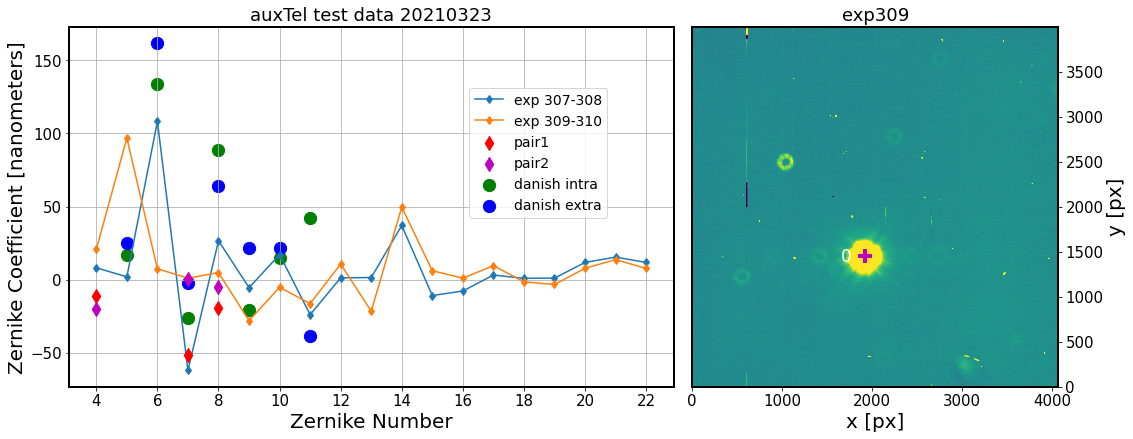

In [18]:
# plot the truth vs simulation... 
exp=309
year='2021'
monthDay='0323'

# plot the figure ...   
fig = plt.figure(figsize=(14, 5))

####################################
### left - plot the fit results  ###
#################################### 

#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,0.6,1])  

for exp in [307,309]:
    zkResultsFile = f'zerDic_{year}{monthDay}00{exp}_{exp+1}_n.npy'
    zkResults = np.load(zkResultsFile, allow_pickle=True).item()
    zkRaw = zkResults['outputZernikesRaw'][0]
    for i in range(len(zkRaw)):
        ax1.plot(np.arange(4, 23),1000*zkRaw[i], 
                 '-d', label=f'exp {exp}-{exp+1}')

ax1.scatter([8,7,4], [-19.40256, -51.19022, -11.11000], 
            c='r', marker='d',s=100,zorder=10,label='pair1')

ax1.scatter([8,7,4], [-5.156342491620025, 0.6554215087770965, -19.8341551660864],
            c='m', marker='d',s=100,zorder=10,label='pair2')

danish_4_11_intra_nm = [-3104.618,17.177,134.087,-26.133,88.511,-20.925,14.620 ,41.928]
danish_4_11_extra_nm = [2951.144,24.803,161.688 ,-2.071,64.181,21.840,21.485,-38.272]

ax1.scatter(np.arange(5,12), danish_4_11_intra_nm[1:], s=150, c='green', label='danish intra')
ax1.scatter(np.arange(5,12), danish_4_11_extra_nm[1:], s=150, c='blue',label='danish extra')

ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()

ax1.set_title(f'auxTel test data {year}{monthDay}', fontsize=18)


###############################################
### right - plot the postISR image ###
###############################################

ax2 = fig.add_axes([0.6,0,0.4,1])
butler = dafButler.Butler('/repo/main/')
datasetRefOrType='postISRCCD'; collection='u/scichris/Latiss/postISRtest'
exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{exp}')
                                                }, collections=[collection])
zscale = ZScaleInterval()
data = exposure_intra.image.array
vmin, vmax = zscale.get_limits(data)

ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)

donutStamps = zkResults['donutStampsExtra'][0]
nrows = len(donutStamps)
for i in range(nrows):
    donut = donutStamps[i]
    xy = donut.centroid_position

    # plot the cross marking that the donut was used 
    ax2.scatter(xy[0],xy[1],s=200,marker='+',c='m', lw=4)
    
    # plot the donut number on the plot 
    xtext,ytext = xy[0],xy[1]
    ytext -= 60
    if xtext+100 > 4096:
        xtext -= 250
    if len(str(i))>1: # move to the left label thats too long 
        #print(i, 'moving')
        xtext -=340 
    else:
        xtext -=260
    ax2.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
ax2.yaxis.tick_right()
ax2.set_xlabel('x [px]')
ax2.set_ylabel('y [px]')
ax2.yaxis.set_label_position("right")
ax2.set_title(f'exp{exp}')